Home work - feature engineering 
--- 

На лекциях 6 и 7 мы рассмотрели много приемов, как можно строить прогнозы, используя не только классические модели временных рядов. 

В этом домашнем задании я предлагаю вам проявить свободу творчества и попробовать различные методы. 
Здесь будут гайдлайны - советы, но им не обязательно следовать строго.

Вы можете приложить два ноутбука - один "черновик", где вы пробуете различные методы и делаете свои выводы. Второй - "чистовик" с оптимальной моделью, графиком и результатами.

Временной ряд №1
----

In [1]:
import pandas as pd
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from plotly.graph_objects import * 
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from xgboost import XGBRegressor
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
import category_encoders as ce
from sklearn.metrics import mean_absolute_error
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
import seaborn as sns
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(12, 8)})
# sns.set(font_scale=2)
# sns.set_style("whitegrid")


from sklearn.ensemble import RandomForestRegressor

In [2]:
df1 = pd.read_csv('../datatest/monthly-car-sales.csv')

Задание:
---
* Задача стоит построить прогноз на следующий год на все 12 месяцев.
* Построить признаки, основанные на времени (месяц, код), а также используя target encoding
* Построить признаки, основанные на lagged values
* Посмотреть, какие признаки работают лучше, возможно стоит скомбинировать? 
* При тестировании лучше всего пользоваться кросс-валидацией. Можно библиотекой. 

<AxesSubplot:>

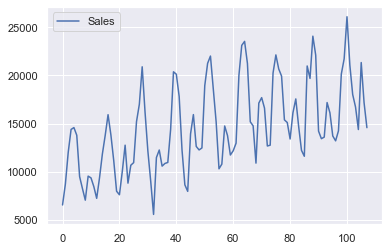

In [3]:
df1.plot()

In [100]:
df2 = df1.copy()
df2['ms'] = pd.to_datetime(df2['Month'])
df2['month'] = df2['ms'].dt.month
df2['year'] = df2['ms'].dt.year

df2.drop('Month',axis=1,inplace=True)
df2.set_index('ms', inplace=True)

# Add features

In [101]:
### lagged features

features = [f'i-{i}' for i in range(12,25)]
for i in range(12,25): 
    df2['i-'+str(i)] = df2['Sales'].shift(i)

In [102]:
### rolling feature

df2['rolling_mean_3m'] = df2['Sales'].rolling(window=3, closed='left').mean()

In [103]:
### rolling mean by calendar years

rolling_month = pd.DataFrame(columns=['Sales'])
for i in range(1,13): 
    rolling_month_tmp = df2[df2.month==i][['Sales']].rolling(window=3, closed='left').mean()
    rolling_month = pd.concat([rolling_month,rolling_month_tmp])
    
rolling_month.dropna(inplace=True)
rolling_month.rename({'Sales':'rolling_mean_by_3m'},axis=1,inplace=True)

In [104]:
df2 = pd.merge(df2, rolling_month,how='left', left_index=True, right_index=True)

In [105]:
test_size = 12
train, test = df2[:-test_size], df2[-test_size:]

In [106]:
mu = 0.5
month_avg = train.groupby('month')[['Sales']].mean()
month_cnt = train.groupby('month')[['Sales']].count()
avg_sales = train['Sales'].mean()

In [107]:
mu_estimate = ((month_cnt * month_avg + \
                mu*avg_sales) / (month_cnt + mu)).reset_index().rename({'Sales':'mu_month'},axis=1)

In [108]:
df2 = pd.merge(df2, mu_estimate, how='left', on=['month'])

In [109]:
df2.columns

Index(['Sales', 'month', 'year', 'i-12', 'i-13', 'i-14', 'i-15', 'i-16',
       'i-17', 'i-18', 'i-19', 'i-20', 'i-21', 'i-22', 'i-23', 'i-24',
       'rolling_mean_3m', 'rolling_mean_by_3m', 'mu_month'],
      dtype='object')

# Build model

In [110]:
features = ['month', 'year', 'i-12','i-18', 'i-17','i-20', 'i-24', 'rolling_mean_by_3m', 'mu_month']

In [111]:
# your code
df3 = df2[['Sales'] + features].dropna().copy()
df3 = df3.reset_index(drop=True)

r2_list = list()
mae_list = list()
n_splits = 4 
test_size = 12 
s = df3
size = len(s)
for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train = s[0:idx]
    test = s[idx:idx+test_size]
    rest = s[idx+test_size:]
    
    mod = RandomForestRegressor()
    mod.fit(train[features], train['Sales'])
    predictions = mod.predict(test[features])
    
    mae_list.append(mean_absolute_error(test['Sales'], predictions))
    r2_list.append(r2_score(test['Sales'], predictions))
print(f'MAE = {np.mean(mae_list)}, R2 = {np.mean(r2_list)}')

MAE = 1558.4416666666666, R2 = 0.7207243616918504


In [40]:
### check all features and leave most important
s = pd.Series(index=features, data = mod.feature_importances_).sort_values(ascending=False)
s

mu_month              0.332136
rolling_mean_by_2m    0.225869
i-12                  0.224011
i-24                  0.092072
i-18                  0.027270
month                 0.015053
i-20                  0.013745
i-17                  0.013676
i-23                  0.008233
i-16                  0.008079
i-19                  0.008004
i-13                  0.007025
i-15                  0.006516
i-22                  0.005612
i-21                  0.005587
i-14                  0.004363
year                  0.002749
dtype: float64

Временной ряд №2
---
Колонки
* Period - дата 
* Revenue - Доход (таргет)
* Sales_quantity - количество проданных товаров. Можно использовать как признак, но только не в текущий момент времени, так как мы не знаем, сколько мы товаров продадим на момент прогноза
* Average_cost - средняя цена товара (Revenue / Sales_quantity) 

In [2]:
df2 = pd.read_csv('../datatest/month_value.csv')

In [3]:
df2.head()

,Period,Revenue,Sales_quantity,Average_cost
0,01.01.2015,1.601007e+07,12729.0,1257.763541
1,01.02.2015,1.580759e+07,11636.0,1358.507000
2,01.03.2015,2.204715e+07,15922.0,1384.697024
3,01.04.2015,1.881458e+07,15227.0,1235.606705
4,01.05.2015,1.402148e+07,8620.0,1626.621765


In [4]:
# correlations
df2.corr()

,Revenue,Sales_quantity,Average_cost
Revenue,1.000000,0.887570,0.358278
Sales_quantity,0.887570,1.000000,-0.093599
Average_cost,0.358278,-0.093599,1.000000


Задание 
---
Используя предыдущие приемы, а так же добавив еще признаки из датасета, так же построить прогноз на 3 месяца и на год вперед